# Assignment 2

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2023/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday March 27th, 2023 at 23:55. Hand in your files via [http://peergrade.io](http://peergrade.io/). If you're not already a peergrade user, [you can use this link to sign up]( 
https://app.peergrade.io/join/44E47G) - **PLEASE USE YOUR DTU EMAIL WHEN YOU SIGN UP**.

**Peergrading date and time**: \[OPTIONAL FOR ASSIGNMENT 2\] _Remember that after handing in you MAY evaluate a few assignments written by other members of the class_. (Should you choose to do this, the deadline is Tuesday April 11 at noon). 

## A2: A short data story

This assignment is to create a short data-story based on the work we've done in class so far. See **Exercises Week 8, Part 2** for full details on how the story should be constructed.

In [1]:
#### Exercise 1 ### 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.family"] = "Garamond"
plt.rcParams['axes.facecolor'] = "#FFF6E9"
plt.rcParams['axes.facecolor'] = "#FFF6E9"

# Load Data 
report_data = pd.read_csv("../../Datasets/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")

# Extract datetime elements 
report_data["Hour"] = pd.to_datetime(report_data["Time"], format="%H:%M").dt.hour
report_data["year"] = pd.to_datetime(report_data.Date, format = "%m/%d/%Y").dt.year

# Only <2018 data 
report_data = report_data.query("year != 2018")

# Lower everything but leading character 
report_data.Category = report_data.Category.apply(lambda x: x.title())

# Subset to only include focus-crimes 
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])
focuscrimes = [crime.title() for crime in focuscrimes]
report_data = report_data[report_data['Category'].isin(focuscrimes)]

# Resolved vs Unresolved crimes 
report_data.Resolution = report_data.Resolution.apply(lambda x: "Unresolved" if x=="NONE" else "Resolved")

Development in reportered v. unreported crimes by year in SF 

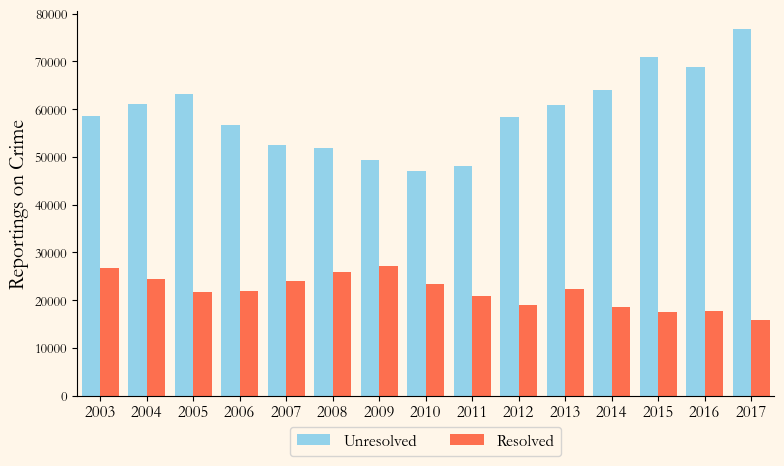

In [2]:
resolution_by_year = report_data.groupby("year").Resolution.value_counts(normalize=False).rename("Reports").reset_index()

fig, ax = plt.subplots(figsize = (9,5))
fig.patch.set_facecolor("#FFF6E9")

sns.barplot(data = resolution_by_year, x=  "year", y = "Reports", hue = "Resolution",
            palette = ["skyblue","#FD603E"], saturation = 1, alpha = 0.9, ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove title from the legend and place below plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[2:], 
          labels=labels[2:], 
          loc='upper center', 
          bbox_to_anchor=(0.5, -0.06),
          ncol = 2,
          fontsize="large")


plt.title("", size = 15)
plt.xlabel("")
plt.ylabel("Reportings on Crime", size = 15)
plt.savefig("../../Plots/res_v_unres_by_year_nonstacked.png", dpi = 300, bbox_inches="tight")
plt.xticks(rotation=0, size =12)

plt.show()

Maybe this one instead:

Distribution of Resolved v. Unresolved Crime Reportings by Year

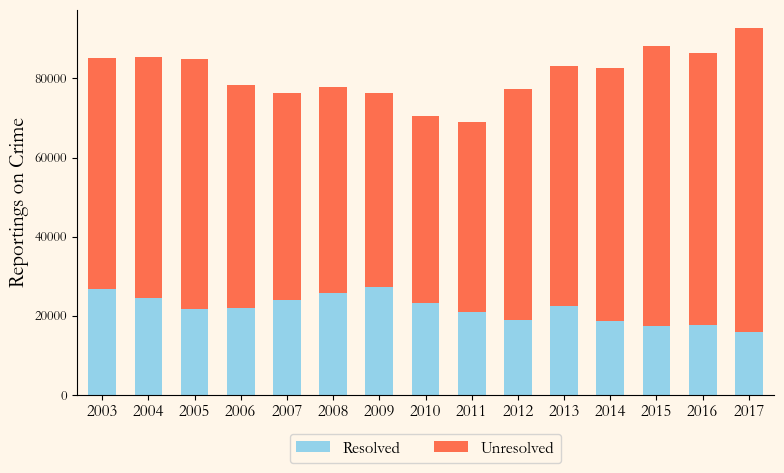

In [3]:
fig, ax = plt.subplots(figsize = (9,5))
fig.patch.set_facecolor("#FFF6E9")

# Pivot dataframe 
resolved_v_unresolved_by_year = resolution_by_year.pivot(index = "year", values = "Reports", columns = "Resolution")

# Plot
resolved_v_unresolved_by_year.plot.bar(stacked="True", color = ["skyblue","#FD603E"], ax = ax, width = 0.6, alpha = 0.9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove title from the legend and place below plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[2:], 
          labels=labels[2:], 
          loc='upper center', 
          bbox_to_anchor=(0.5, -0.08),
          ncol = 2,
          fontsize="large")

plt.title("", size = 15)
plt.xlabel("")
plt.ylabel("Reportings on Crime", size = 15)
plt.xticks(rotation=0, size =12)
plt.savefig("../../Plots/res_v_unres_by_year_stacked.png", dpi = 300, bbox_inches="tight")
plt.show()

## Geomap of Unresolved Crime


Resolved crimes by district 

Get neighborhood data from https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4

In [4]:
import geopandas as gpd

SF_geojson = gpd.read_file("data_for_assignment_2/SF Find Neighborhoods.geojson")[["name", "geometry"]]
SF_geojson.columns = ["Neighborhood", "geometry"]

Get Long and Lat from SF Crime Data

In [5]:
# convert latitude and longitude to point 
report_data_subset = report_data[["Resolution", "Category", "X", "Y", "PdDistrict", "year"]].copy()

n_before_outlier_removal = report_data_subset.shape[0]

# Remove geographical outlier --> probably when the police do not know where the crime happend
report_data_subset = report_data_subset[(report_data_subset.Y < 50) & (report_data_subset.X<-122)]

n_after_outlier_removal = report_data_subset.shape[0]

print(f"Removed {n_before_outlier_removal - n_after_outlier_removal} geographical ouliers ")

Removed 71 geographical ouliers 


Convert to GeoPandas

In [6]:
gpd_report_data = gpd.GeoDataFrame(
                  report_data_subset, 
                  geometry=gpd.points_from_xy(report_data_subset.X, report_data_subset.Y),
                  crs = "EPSG:4326")

gpd_report_data.columns = ["Resolution", "Category", "Lon", "Lat", "District", "year", "geometry"]

In [7]:
# Reverse geocode --> Join Point on Multipolygons 
crime_by_neighborhood = gpd.sjoin(SF_geojson, gpd_report_data)

print(f"OBS Duplicates after merge: {crime_by_neighborhood.shape[0] - gpd_report_data.shape[0]}")

OBS Duplicates after merge: 3422


Calculate share of reported crimes that remain unresolved by Neighborhood

In [8]:
share_of_resolution_by_neighborhood = crime_by_neighborhood.groupby("Neighborhood").Resolution.value_counts(normalize = True).rename("resolution_share").reset_index()
share_of_unresolved_by_neighborhood = share_of_resolution_by_neighborhood.query("Resolution == 'Unresolved'").copy()
share_of_unresolved_by_neighborhood = share_of_unresolved_by_neighborhood[['Neighborhood', 'resolution_share']]
share_of_unresolved_by_neighborhood.resolution_share = share_of_unresolved_by_neighborhood.resolution_share.apply(lambda share: round(share, ndigits = 2))

Calculate total number of reported crimes by Neighborhood

In [9]:
total_report_by_neighborhood = crime_by_neighborhood.groupby("Neighborhood").size().rename("Reports_in_total").reset_index()

Regression of `Share of Unresolved Reportings` on `Years` 

In [10]:
import numpy as np

def linear_regression(x, y):
    """
    Calculates the slope and intercept for a linear regression.

    Parameters:
        x (array-like): The independent variable.
        y (array-like): The dependent variable.

    Returns:
        slope (float): The slope of the linear regression line.
        intercept (float): The intercept of the linear regression line.
    """
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = len(x)

    # Calculate the slope and intercept of the linear regression line
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sum((x - x_mean) ** 2)
    slope = numerator / denominator
    intercept = y_mean - slope * x_mean

    return slope, intercept

Set starting time (i.e. 2003) = 0

In [11]:
crime_by_neighborhood["year"] = crime_by_neighborhood["year"]-2003

Calculate share of unresolved reportings by year within each neighborhood

In [12]:
unresolved_by_neigh_and_year = crime_by_neighborhood.groupby(["Neighborhood", "year"]).Resolution.value_counts(normalize = True).rename("resolution_share").reset_index()
unresolved_by_neigh_and_year = unresolved_by_neigh_and_year.query("Resolution == 'Unresolved'")
unresolved_by_neigh_and_year.sort_values(["Neighborhood", "year"], inplace = True)

 Regress `Share of Unresolved Reportings` on `Years` within each neighborhood 

In [13]:
reg_data = []

for n_hood in unresolved_by_neigh_and_year.Neighborhood.unique():
    n_hood_data = unresolved_by_neigh_and_year.query(f"Neighborhood == '{n_hood}'").sort_values("year")
    slope, intercept = linear_regression(n_hood_data.year, n_hood_data.resolution_share)
    slope_in_pct_point = slope * 100
    reg_data.append([n_hood, round(slope_in_pct_point, 2)])


reg_df = pd.DataFrame(reg_data, columns = ["Neighborhood", "Slope"])

Merge `Total number of Reportings`, `Share of Unresolved Reportings` and the `Regression Coefficient` of `Share of Unresolved Reportings` on `Years`

In [14]:
neighborhood_crime_data = total_report_by_neighborhood.merge(share_of_unresolved_by_neighborhood).merge(reg_df)

Merge `neighborhood_crime_data` with GeoData 

In [15]:
geo_data = SF_geojson.merge(neighborhood_crime_data).set_index("Neighborhood")

## Plot geomap

In [16]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import json

label_dict = {'Reports_in_total': "Reports in Total", 'resolution_share': "Share of Unresolved Reportings", "Slope":"%-point Change in Share of Unresolved Crime Per Year (2003-2017)"}
# we need to add this to select which trace 
# is going to be visible
visible = np.array(list(label_dict.keys()))

# define traces and buttons at once
traces = []
buttons = []
for col, label in label_dict.items():

    traces.append(go.Choroplethmapbox(geojson=json.loads(geo_data.to_json()),
                                    z = geo_data[col],
                                    locations = geo_data.index,
                                    colorscale="ylorbr",
                                    #colorbar_title = label,
                                    colorbar=dict(
                                        title=label,
                                        titleside='top',
                                        len = 0.8,
                                        orientation = "h",
                                        y = -0.165,
                                        tickfont = dict(size=15) # set the position of the colorbar title
                                    ),
                                    visible= True if col==list(label_dict.keys())[0] else False,
                                    hovertemplate= f"""{label}: """ +  """%{z}<br>Neighborhood: %{text}<extra></extra>""",
                                    text = geo_data.index))

    buttons.append(dict(label=label,
                        method="update",
                        args=[{"visible":list(visible==col)},
                              {"title":""}]))

updatemenus = [{"active":0,
                "buttons":buttons,
                "direction":'down',
                "showactive":True,
                "x":0.02,
                "y":0.98,
                "xanchor":"left",
                "yanchor":"top"}]


# Show figure
fig = go.Figure(data=traces,
                layout=dict(updatemenus=updatemenus))

fig.layout['title']['text'] = ""

fig.update_layout(mapbox_style="carto-positron",
                    height = 600,
                    width = 1000,
                    autosize=True,
                    paper_bgcolor= "#FFF6E9",
                    margin={"r":0,"t":0,"l":0,"b":0},
                    mapbox=dict(center={"lat": 37.771, "lon": -122.4256},zoom=11.1),
                    font_family = "Garamond",
                    font_size = 18
                    )

fig.show()

In [17]:
fig.write_html("../../Plots/SF_unresolved_crime.html")

# Interactive plot - Resolution by crime type

Colormap for Bokeh plot

In [18]:
import matplotlib.colors as mcolors

DISCRETE_COLORS = [
    "#3D4D55", 
    "#AF6F41",  
    "#44463E", 
    "#EAE7E3", 
    "#2A6271", 
    "#337F64", 
    "#90A48F", 
    "#BEBCA9"]

N_colors = len(focuscrimes)

CONTINUOUS_COLORS = mcolors.LinearSegmentedColormap.from_list(
    "Custom", DISCRETE_COLORS, N=N_colors
)

HEXCOLOR_LIST = [mcolors.rgb2hex(CONTINUOUS_COLORS(i)) for i in range(N_colors)]

Arrange data 

In [19]:
# Count share of resolution by crime type by year  
category_resolution_share_by_year = report_data.groupby(["year", "Category"]).Resolution.value_counts(normalize = False).rename("Count").reset_index()
#category_unresolved_share_by_year = category_resolution_share_by_year.query("Resolution == 'Unresolved'")
category_unresolved_share_by_year = category_resolution_share_by_year.pivot(values = "Count", index = ["year", "Resolution"], columns = "Category").fillna(0).reset_index()

# Ved ikke hvorfor, men det her var vigtigt! 
category_unresolved_share_by_year.year =category_unresolved_share_by_year.year.astype(str)
category_unresolved_share_by_year.head(2)

Category,year,Resolution,Assault,Burglary,Disorderly Conduct,Driving Under The Influence,Drug/Narcotic,Drunkenness,Larceny/Theft,Prostitution,Robbery,Stolen Property,Trespass,Vandalism,Vehicle Theft,Weapon Laws
0,2003,Resolved,4187,806,629,281,9201,613,3636,1895,1064,622,1102,694,1290,746
1,2003,Unresolved,7222,5207,248,6,583,44,22549,42,2049,154,299,5683,13986,450


Bokeh stacked barplot with tabs 

In [20]:
from bokeh.models import ColumnDataSource, FactorRange, Legend, CustomJS, Dropdown
from bokeh.io import show, curdoc
from bokeh.models import Panel, Tabs
from bokeh.plotting import figure, show, output_file
from bokeh.themes import Theme
from bokeh.resources import Resources

output_file("../../Plots/uresolved_by_crimetype.html")

source = ColumnDataSource(category_unresolved_share_by_year) # convert df to bokeh format

years = [str(year) for year in range(2003,2018)]

curdoc().theme = Theme(filename="sandy_theme.json")

hue_and_legend = ["Resolved", "Unresolved"]


tabs = []

### Loop over crimes 
for crime, color in zip(sorted(focuscrimes), HEXCOLOR_LIST):

    #Subset by crime and rearrange dataformat 
    res_v_unres_for_sub_crime = category_unresolved_share_by_year[["year", "Resolution", crime]]
    res_v_unres_for_sub_crime = res_v_unres_for_sub_crime.pivot(values = crime, index="year", columns = "Resolution").reset_index()
    source = ColumnDataSource(res_v_unres_for_sub_crime) # convert df to bokeh format

    p = figure(x_axis_label = "Year",
            y_axis_label = "Reported Crimes", 
            title = f"Resolved and Unresolved Crimes on {crime} from 2003-2017",
            width = 1000,
            toolbar_location="above",
            x_range = FactorRange(factors=years),
            tools="save")

    p.vbar_stack(hue_and_legend,
        x="year",
        source=source,
        width = 0.8,
        color = [color, "#FD603E"],
        alpha = 0.8,
        legend_label=hue_and_legend)
    
    p.legend.location = "center"
    p.legend.orientation = "horizontal"
    p.add_layout(p.legend[0], 'below')
    p.legend.click_policy="mute"

    # Remove x-grid and "floor" the bars to y=0.
    p.xgrid.grid_line_color = None
    p.y_range.start = 0

    tab = Panel(child=p, title=crime)

    tabs.append(tab)

show(Tabs(tabs=tabs, background = "#FFF6E9"))